In [1]:
!pip install watermark

In [2]:
!pip install shap

In [3]:
import shap
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics  import ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency

from scipy.stats import f_oneway
import plotly.express as px
# from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from watermark import watermark
import syslog
import missingno as msno
from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from google.colab import drive

import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

## **Documentação do Dataset**

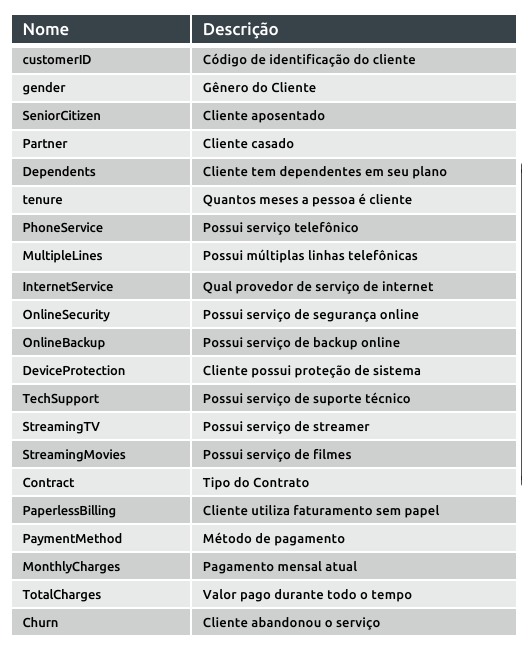

### **Montando o Diretorio de Dados**

In [4]:
drive.mount( "/content/drive", force_remount=True )

Mounted at /content/drive


### **Definições Gerais**

In [5]:
DIR_RAIZ = "/content/drive/MyDrive"
DIR_BASE = "LocalCases"
DIR_DATASET  = "Dataset"
NOME_DATASET = "Customer-Churn - Customer-Churn.csv"
ARQUIVO_DATASET = str(Path(DIR_RAIZ, DIR_BASE, DIR_DATASET, NOME_DATASET))
BUG = False
SEMENTE = 1965
Componentes = [ "gender", "Partner", "Dependents", "PhoneService",
                "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
                "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
                "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]
pd.set_option('max_colwidth', 800)

### **Funções Necessárias**

In [6]:
def DocumentacaoMaquina ():
    print ( "########################################################################" )
    print ( "# Documentação da Máquina Utilizada" )
    print ( "########################################################################" )
    print(watermark())
    return


In [7]:
def DocumentacaoBibliotecas ():
    print ( "########################################################################" )
    print ( "# Documentação das Bibliotecas Utilizadas" )
    print ( "########################################################################" )
    print(watermark(packages= "shap," +
                              "pathlib," +
                              "sklearn," +
                              "scipy,"+
                              "plotly,"+
                              "pandas,"+
                              "numpy,"+
                              "seaborn,"+
                              "matplotlib,"+
                              "watermark,"+
                              "missingno,"+
                              "imblearn,"+
                              "google"))
    return

In [8]:
def VerificaCategorico (Componente):
    TipoCategoria = ['object', 'category', 'bool', 'int64']
    if Componente.dtype.name in TipoCategoria:
        return "Sim"
    else:
        return "Não"

In [9]:
def MapaDados ( tempdfDados ):
    tempComponentes = tempdfDados.columns
    tempComponentes = tempComponentes.drop(tempComponentes[0])

    TipoColunas = tempdfDados.dtypes
    TipoColunas = TipoColunas.drop(TipoColunas.index[0])
    ExcecaoColunas = ['tenure', 'MonthlyCharges', 'TotalCharges']
    dfTemp = pd.DataFrame({'Componente':TipoColunas.index, 'Tipo':TipoColunas.values, "Categorico":"", "Valor Categorico":"", "Minimo":"", "Maximo":""})

    for iAux in range(0, len(tempComponentes)):
        dfTemp["Minimo"][iAux] = np.min(dfOriginal[tempComponentes[iAux]])
        dfTemp["Maximo"][iAux] = np.max(dfOriginal[tempComponentes[iAux]])

        if any(tempComponentes[iAux] in iLista for iLista in ExcecaoColunas):
            dfTemp["Valor Categorico"][iAux] = "[N/A]"
            dfTemp["Categorico"][iAux] = "Não"
        else:
          iValor = pd.unique(dfOriginal[tempComponentes[iAux]].values.ravel())
          dfTemp["Valor Categorico"][iAux] = iValor.tolist()
          dfTemp["Categorico"][iAux] = VerificaCategorico (dfOriginal[tempComponentes[iAux]])

    return (dfTemp)

In [10]:
def VerificaErros (tempOriginal, tempDados, tempCampo):
    lstOriginal = []
    lstResultado = []

    CamposUnicos = tempOriginal[tempCampo].unique()
    for iAux in range (0, len(CamposUnicos)):
        Resultado = tempOriginal[tempOriginal[tempCampo]==CamposUnicos[iAux]].shape[0]
        lstOriginal.append (Resultado)

    CamposUnicos = tempDados[tempCampo].unique()
    for iAux in range (0, len(CamposUnicos)):
        Resultado = tempDados[tempDados[tempCampo]==CamposUnicos[iAux]].shape[0]
        lstResultado.append (Resultado)

    iTotal = 0
    for iAux in range (0, len(lstOriginal)):
        if ( lstOriginal[iAux] == lstResultado[iAux] ):
            iTotal = iTotal + 1

    if ( iTotal == len(lstOriginal)):
        Mensagem = "Sucesso"
    else:
        Mensagem = "Falha"

    return (Mensagem)

In [11]:
def DesenhaDensidades (dfDadosTemp, ComponenteTemp ):
    Grafico = plt.figure( figsize=(8, 5))
    sns.set_style("darkgrid")
    sns.kdeplot ( x = dfDadosTemp[ComponenteTemp], lw=2, shade=True, hue = dfDadosTemp["Churn"] )
    plt.title("Distribuição de Densidades", fontsize=11, fontweight="bold")
    plt.ylabel("Densidade", fontsize=11, fontweight="bold")
    plt.xlabel(ComponenteTemp, fontsize=11, fontweight="bold")
    plt.show()
    return

In [12]:
def CalculaPerdas ( dfDadosTemp ):
    dfChurn = dfDados [dfDados["Churn"] == 1]
    dfChurn = dfChurn.reset_index()

    dfCliente = dfDados [dfDados["Churn"] == 0]
    dfCliente = dfCliente.reset_index()
    PerdaChurn = 0.0
    for iAux in range(0,len(dfChurn)):
        Meses = dfChurn["tenure"][iAux]
        Total = dfChurn["TotalCharges"][iAux]
        PerdaChurn = PerdaChurn + (Total / Meses)

    TamanhoGanho = 0.0
    for iAux in range(0,len(dfCliente)):
        Meses = dfCliente["tenure"][iAux]
        Total = dfCliente ["TotalCharges"][iAux]
        if ( Meses > 0 and Total > 0):
          TamanhoGanho = TamanhoGanho + (Total / Meses)

    return (PerdaChurn, TamanhoGanho)

In [13]:
def MinhaFuncao (pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

In [14]:
def DesenhaPizza (dfChurnTemp, dfClienteTemp, ComponenteTemp, Titulo1, Titulo2, LegendaTemp):
    Grafico = plt.figure( figsize=(10, 8))
    sns.set_style("darkgrid")

    lstQuantidade = []
    Tamanho = len (pd.unique( dfClienteTemp[ComponenteTemp].values.ravel()))
    for iAux in range (0, Tamanho):
        lstQuantidade.append (dfClienteTemp[dfClienteTemp[ComponenteTemp]==iAux].shape[0])

    Grafico.add_subplot(1, 2, 1 )
    plt.title(Titulo1, fontsize=11, fontweight="bold")

    plt.pie (
            lstQuantidade,
            textprops=dict(color="w"),
            autopct=lambda pct: MinhaFuncao(pct,lstQuantidade),
            startangle=0,
            wedgeprops = {
                            "linewidth" : 3,
                            "edgecolor" : "black"
                         },
            )
    plt.legend(LegendaTemp, bbox_to_anchor = (0.1, .3))

    lstQuantidade = []
    Tamanho = len (pd.unique( dfChurnTemp[ComponenteTemp].values.ravel()))
    for iAux in range (0, Tamanho):
        lstQuantidade.append (dfChurnTemp[dfChurnTemp[ComponenteTemp]==iAux].shape[0])

    Grafico.add_subplot(1, 2, 2 )
    plt.title(Titulo2, fontsize=11, fontweight="bold")

    plt.pie (
            lstQuantidade,
            textprops=dict(color="w"),
            autopct=lambda pct: MinhaFuncao(pct,lstQuantidade),
            startangle=0,
            wedgeprops = {
                            "linewidth" : 3,
                            "edgecolor" : "black"
                         },
            )

    plt.legend(LegendaTemp, bbox_to_anchor = (0.1, .3))

    plt.show()
    return


In [15]:
def ContaClientes ( dfDadosTemp ):
    dfChurn = dfDadosTemp [dfDadosTemp["Churn"] == 1]
    dfChurn = dfChurn.reset_index()

    dfCliente = dfDadosTemp [dfDadosTemp["Churn"] == 0]
    dfCliente = dfCliente.reset_index()

    ClientesPerdidos = dfChurn ["customerID"].count ()
    ClientesAtuais = dfCliente ["customerID"].count ()

    return ( ClientesPerdidos, ClientesAtuais )

In [16]:
def MontaPizza ( Labels, Quantidade, Titulo ):
    Grafico = plt.figure( figsize=(6, 4))
    sns.set_style("darkgrid")

    plt.title(Titulo, fontsize=11, fontweight="bold")
    plt.pie (
            Quantidade,
            labels = Labels,
            autopct = "%1.2f%%",
            wedgeprops = {
                            "linewidth" : 3,
                            "edgecolor" : "black"
                        },
            startangle=90
            )

    plt.axis("equal")
    plt.tight_layout()
    plt.show()
    return

# **Documentação do Ambiente**

## **Documentação do Ambiente**

In [17]:
DocumentacaoMaquina ()

########################################################################
# Documentação da Máquina Utilizada
########################################################################
Last updated: 2023-11-27T06:02:43.510628+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.120+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



## **Documentação das Bibliotecas Utilizadas**

In [18]:
DocumentacaoBibliotecas ()

########################################################################
# Documentação das Bibliotecas Utilizadas
########################################################################
shap      : 0.43.0
pathlib   : 1.0.1
sklearn   : 1.2.2
scipy     : 1.11.3
plotly    : 5.15.0
pandas    : 1.5.3
numpy     : 1.23.5
seaborn   : 0.12.2
matplotlib: 3.7.1
watermark : 2.4.3
missingno : 0.5.2
imblearn  : 0.10.1
google    : 2.0.3



# **Leitura dos Dados**

In [19]:

try:
    dfOriginal = pd.read_csv( ARQUIVO_DATASET, decimal=",")

except FileNotFoundError:
    syslog.syslog(syslog.LOG_ERR, f"Não Foi Localizado o Dataset: {NOME_DATASET}")
    print ( "Não Foi Localizado o Dataset:", NOME_DATASET)
    BUG = True

except pd.errors.EmptyDataError:
    syslog.syslog(syslog.LOG_ERR, f"Dataset {NOME_DATASET} Está Vazio")
    print (f"Dataset {NOME_DATASET} Está Vazio")
    BUG = True

except pd.errors.ParserError:
    syslog.syslog(syslog.LOG_ERR, f"Erro no Parsing do Dataset {NOME_DATASET}")
    print ( f"Erro no Parsing do Dataset {NOME_DATASET}")
    BUG = True

except Exception:
    syslog.syslog(syslog.LOG_ERR, f"Occoreu uma Exceção no Dataset: {NOME_DATASET}")
    print ( f"Occoreu uma Exceção no Dataset: {NOME_DATASET}")
    BUG = True

if ( BUG ):
    exit ()

## **Verificando se Existem Dados Duplicados**

In [20]:
Duplicados = dfOriginal.duplicated().sum()
print ("#####################################################################")
print ("# Verificação de Dados Duplicados")
print ("#####################################################################")
Avaliacao = "Não Há Dados Dupĺicados"
if ( Duplicados >= 1):
    Avaliacao = "Existem Dados Dupĺicados"
print ( "# ", Avaliacao )
print ("#####################################################################")
del (Duplicados, Avaliacao)

#####################################################################
# Verificação de Dados Duplicados
#####################################################################
#  Não Há Dados Dupĺicados
#####################################################################


## **Estrutura das Componentes do Dataset**

In [21]:
MapaDados (dfOriginal)


,Componente,Tipo,Categorico,Valor Categorico,Minimo,Maximo
0,gender,object,Sim,"[Female, Male]",Female,Male
1,SeniorCitizen,int64,Sim,"[0, 1]",0,1
2,Partner,object,Sim,"[Yes, No]",No,Yes
3,Dependents,object,Sim,"[Yes, No]",No,Yes
4,tenure,int64,Não,[N/A],0,72
5,PhoneService,object,Sim,"[Yes, No]",No,Yes
6,MultipleLines,object,Sim,"[Yes, No, No phone service]",No,Yes
7,InternetService,object,Sim,"[Fiber optic, DSL, No]",DSL,No
8,OnlineSecurity,object,Sim,"[Yes, No, No internet service]",No,Yes
9,OnlineBackup,object,Sim,"[Yes, No, No internet service]",No,Yes


## **Avaliação da Cardinalidade dos Dados**

In [22]:
dfCardinalidade = dfOriginal.nunique()
dfCardinalidade = pd.DataFrame ({
                                'Componente':dfCardinalidade.index,
                                'Variabilidade':dfCardinalidade.values
                               })

print ("#####################################################################")
print ("# Avaliação da Cardinalidade")
print ("#####################################################################")

Cabecalho = [ "Componente", "Variabilidade", "Avaliação"]
print(f"{Cabecalho[0]: <17} {Cabecalho[1]: <15} {Cabecalho[2]: <25}")

for iAux in range (len(dfCardinalidade)):

    Avaliacao = "Baixa Cardinalidade"
    if ( dfCardinalidade ["Variabilidade"][iAux] > 1):
       Avaliacao = "Alta Cardinalidade"

    jAux = dfCardinalidade["Componente"][iAux]
    kAux = dfCardinalidade ["Variabilidade"][iAux]

    print(f"{jAux: <17} {kAux: <15} {Avaliacao: <25}")

print ("#####################################################################")

del (Cabecalho, iAux, Avaliacao, jAux, dfCardinalidade, kAux)


#####################################################################
# Avaliação da Cardinalidade
#####################################################################
Componente        Variabilidade   Avaliação                
customerID        7043            Alta Cardinalidade       
gender            2               Alta Cardinalidade       
SeniorCitizen     2               Alta Cardinalidade       
Partner           2               Alta Cardinalidade       
Dependents        2               Alta Cardinalidade       
tenure            73              Alta Cardinalidade       
PhoneService      2               Alta Cardinalidade       
MultipleLines     3               Alta Cardinalidade       
InternetService   3               Alta Cardinalidade       
OnlineSecurity    3               Alta Cardinalidade       
OnlineBackup      3               Alta Cardinalidade       
DeviceProtection  3               Alta Cardinalidade       
TechSupport       3               Alta Cardinalidad

# **Aumentando a Qualidade dos Dados**

## **Convertendo a Base Para Uppercase**

In [23]:
dfDados = dfOriginal.copy()
for iComponente in Componentes:
    dfDados[iComponente] = dfDados[iComponente].apply(lambda x: x.upper())

del (iComponente)

## **Codificando os Labels do Dataset**

In [24]:
EncoderComponente = LabelEncoder()
for iComponente in Componentes:
    dfDados[iComponente] = EncoderComponente.fit_transform(dfDados[iComponente])

del (EncoderComponente, iComponente )

## **Verificando Possíveis Erros No Processo de Codificação**

In [25]:
print ("########################################################################")
print ("# Verificando Possíveis Erros No Processo de Codificação")
print ("########################################################################")

Cabecalho = [ "Campo do Dataset", "Resultado da Avaliação"]
print(f"{Cabecalho[0]: <25} {Cabecalho[1]: <25}")
print ("########################################################################")
for iAux in range (len(Componentes)):
    print(f"# {Componentes[iAux]: <25} {VerificaErros (dfOriginal, dfDados, Componentes[iAux]): <25}")

print ("########################################################################")

del (Cabecalho, iAux)

########################################################################
# Verificando Possíveis Erros No Processo de Codificação
########################################################################
Campo do Dataset          Resultado da Avaliação   
########################################################################
# gender                    Sucesso                  
# Partner                   Sucesso                  
# Dependents                Sucesso                  
# PhoneService              Sucesso                  
# MultipleLines             Sucesso                  
# InternetService           Sucesso                  
# OnlineSecurity            Sucesso                  
# OnlineBackup              Sucesso                  
# DeviceProtection          Sucesso                  
# TechSupport               Sucesso                  
# StreamingTV               Sucesso                  
# StreamingMovies           Sucesso                  
# Contract              

# **Análise de Exploração de Dados**

## **Dimensões do Dataset**

In [26]:
print ("########################################################################")
print ("# Dimensões do Dataset")
print ("########################################################################")
print ("# Número de Linhas ....: ", dfOriginal.shape[0])
print ("# Número de Colunas ...: ", dfOriginal.shape[1])
print ("########################################################################")

########################################################################
# Dimensões do Dataset
########################################################################
# Número de Linhas ....:  7043
# Número de Colunas ...:  21
########################################################################


## **Análise de Dados Faltantes**

In [27]:
Campos = dfDados.columns
lstFaltantes = { "Componente": [], "Faltante": [] }
for iAux in range ( len(Campos)):
    jAux = dfDados[Campos [iAux]].isnull().mean()*100
    lstFaltantes["Componente"].append ( Campos [iAux] )
    lstFaltantes["Faltante"].append ( jAux )

print ("########################################################################")
print ("# Valores Faltantes por Componente")
print ("########################################################################")

Cabecalho = [ "Cliente", "Percentual"]
print(f"{Cabecalho[0]: <20} {Cabecalho[1]: <20}")
for iAux in range (len(lstFaltantes['Componente'])):
    print(f"{lstFaltantes['Componente'][iAux]: <20} {np.round(lstFaltantes['Faltante'][iAux], decimals=2): <20}")

print ("########################################################################")

del (Campos, lstFaltantes, iAux, jAux, Cabecalho)


########################################################################
# Valores Faltantes por Componente
########################################################################
Cliente              Percentual          
customerID           0.0                 
gender               0.0                 
SeniorCitizen        0.0                 
Partner              0.0                 
Dependents           0.0                 
tenure               0.0                 
PhoneService         0.0                 
MultipleLines        0.0                 
InternetService      0.0                 
OnlineSecurity       0.0                 
OnlineBackup         0.0                 
DeviceProtection     0.0                 
TechSupport          0.0                 
StreamingTV          0.0                 
StreamingMovies      0.0                 
Contract             0.0                 
PaperlessBilling     0.0                 
PaymentMethod        0.0                 
MonthlyCharges       

## **Imputando Dados (Método Multivariado)**

In [28]:
dfTemp = dfDados.copy(deep=True)
dfTemp = dfTemp.drop(["customerID"], axis=1)


print ("########################################################################")
print ("# Imputação dos Dados")
print ("########################################################################")
Campos = dfTemp.columns
dfRF = dfTemp.copy(deep=True)
rfImputacao = IterativeImputer ( RandomForestRegressor())
rfImputacao.fit ( dfRF )
RF = rfImputacao.transform ( dfRF )

dfRF = pd.DataFrame    (
                            data = RF,
                            columns = [Campos]
                        )

dfDados["TotalCharges"] = dfRF["TotalCharges"]

print ("# Imputação Realizada com Sucesso")
print ("########################################################################")
del (dfRF, dfTemp, Campos, rfImputacao, RF)


########################################################################
# Imputação dos Dados
########################################################################
# Imputação Realizada com Sucesso
########################################################################


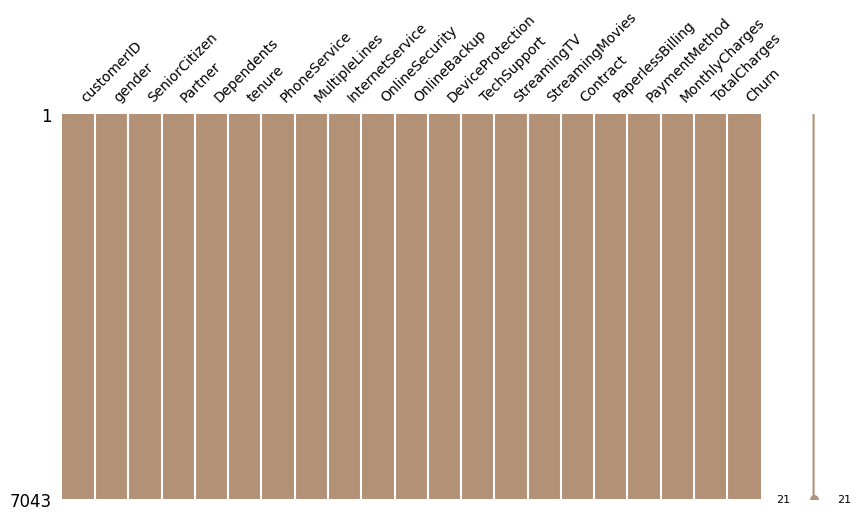

In [29]:
msno.matrix(dfDados, figsize=(10,5), fontsize=10, color=(0.7, 0.57, 0.47));


## **Condições de Balanceamento de Dados**

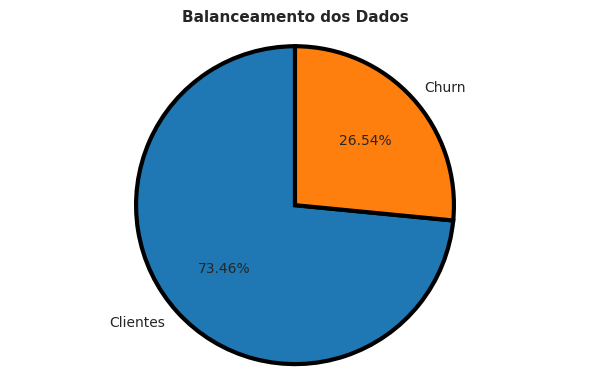

In [30]:
Labels = ["Clientes", "Churn"]
Quantidade = [dfDados["Churn"].value_counts()[0], dfDados["Churn"].value_counts()[1]]

Grafico = plt.figure( figsize=(6, 4))
sns.set_style("darkgrid")

plt.title("Balanceamento dos Dados", fontsize=11, fontweight="bold")
plt.pie (
        Quantidade,
        labels = Labels,
        autopct = "%1.2f%%",
        wedgeprops = {
                        "linewidth" : 3,
                        "edgecolor" : "black"
                     },
        startangle=90
        )

plt.axis("equal")
plt.tight_layout()
plt.show()

del (Labels, Quantidade, Grafico)


## **Mapa de Correlação dos Dados**

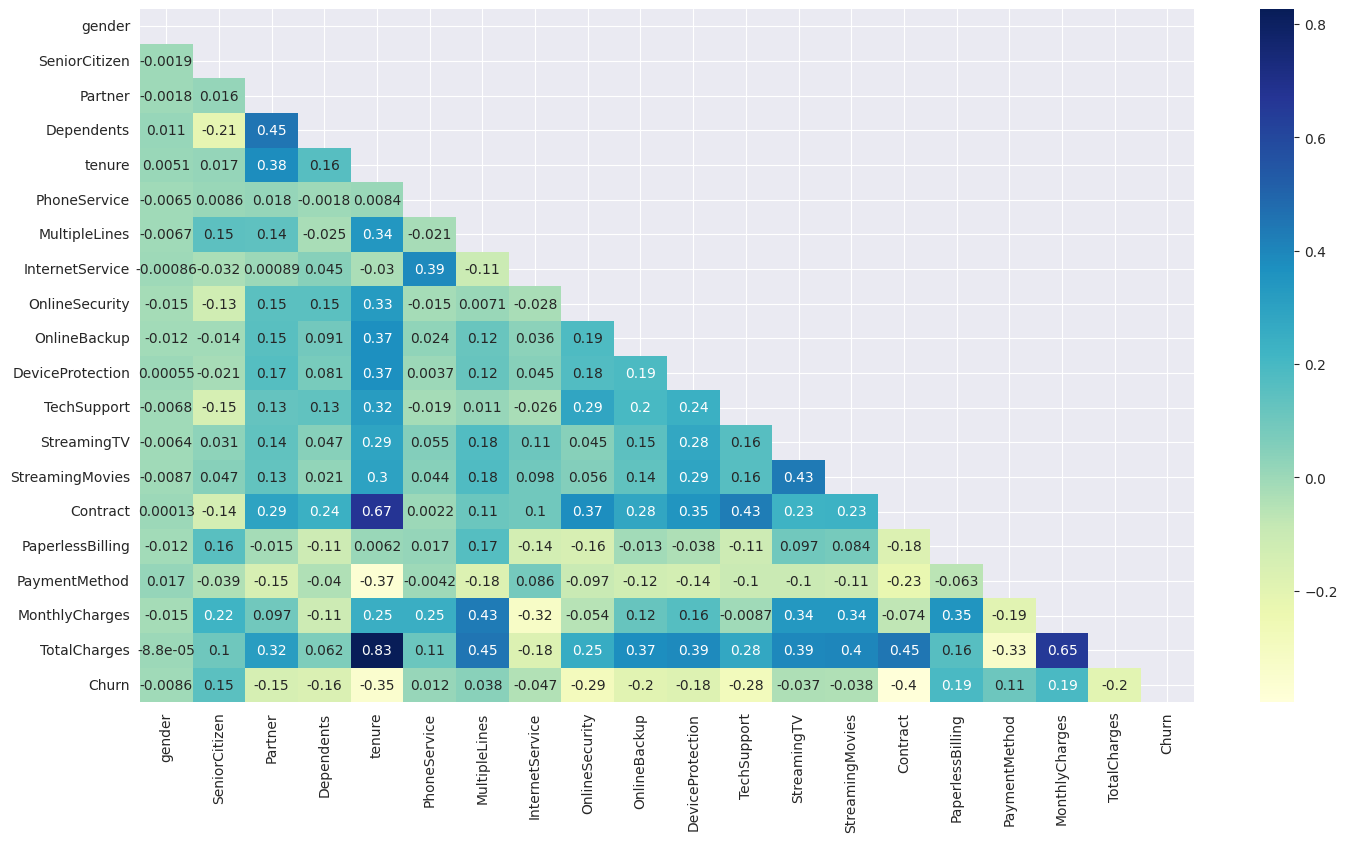

In [31]:
dfTemp = dfDados.copy()
dfTemp = dfTemp.drop(["customerID"], axis=1)

plt.figure(figsize=(17, 9))
Mascara = np.triu(np.ones_like(dfTemp.corr()))
sns.heatmap(dfTemp.corr(), cmap="YlGnBu", annot=True, mask=Mascara)
plt.show()

del (dfTemp, Mascara)


# **Identificando as Variáveis Mais Aderentes ao Problema**

## **Teste ChiQuadrado**

In [32]:
Componentes = [
              "gender", "SeniorCitizen", "Partner", "Dependents",
              "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
              "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
              "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"
              ]
Cabecalho = [ "Variável", "ChiSquare", "p-Valor", "Avaliação"]

print ("##########################################################################")
print ("# Avaliação das Variáveis Mais Aderentes (ChiQuadrado)")
print ("##########################################################################")
print(f"# {Cabecalho[0]: <16} {Cabecalho[1]: <10} {Cabecalho[2]: <25} {Cabecalho[3]: <15}")
print ("##########################################################################")
for Variavel in Componentes:
    Tabela = pd.crosstab(dfOriginal[Variavel],dfOriginal['Churn'])
    chi2,pValor,_,_  = chi2_contingency(Tabela)

    Avaliacao = "Significativa"
    if ( pValor > 0.05 ):
       Avaliacao = "Não Significativa"

    print(f"# {Variavel: <16} {np.round_(chi2, decimals=3): <10} {pValor: <25} {Avaliacao: <15}")

print ("##########################################################################")
del (Componentes, Cabecalho, Variavel, Tabela, chi2, pValor, Avaliacao )


##########################################################################
# Avaliação das Variáveis Mais Aderentes (ChiQuadrado)
##########################################################################
# Variável         ChiSquare  p-Valor                   Avaliação      
##########################################################################
# gender           0.484      0.48657873605618596       Não Significativa
# SeniorCitizen    159.426    1.510066805092378e-36     Significativa  
# Partner          158.733    2.1399113440759935e-36    Significativa  
# Dependents       189.129    4.9249216612154196e-43    Significativa  
# PhoneService     0.915      0.3387825358066928        Não Significativa
# MultipleLines    11.33      0.0034643829548773        Significativa  
# InternetService  732.31     9.571788222840544e-160    Significativa  
# OnlineSecurity   849.999    2.661149635176552e-185    Significativa  
# OnlineBackup     601.813    2.0797592160864276e-131   Significativ

## **Teste ANOVA**

In [33]:
Componentes = [ "tenure", "MonthlyCharges", "TotalCharges"]
Cabecalho = [ "Variável", "Estatistica-F", "p-Valor", "Avaliação"]

print ("##########################################################################")
print ("# Avaliação das Variáveis Mais Aderentes (ANOVA)")
print ("##########################################################################")
print(f"# {Cabecalho[0]: <16} {Cabecalho[1]: <13} {Cabecalho[2]: <25} {Cabecalho[3]: <15}")
print ("##########################################################################")
for Variavel in Componentes:
    Churn = dfDados[dfDados['Churn']==1][Variavel]
    Cliente = dfDados[dfDados['Churn']==0][Variavel]
    EstatisticaF, pValor = f_oneway(Churn,Cliente)

    Avaliacao = "Significativa"
    if ( pValor > 0.05 ):
       Avaliacao = "Não Significativa"

    print(f"# {Variavel: <16} {np.round_(EstatisticaF, decimals=3): <13} {pValor: <25} {Avaliacao: <15}")
print ("##########################################################################")
del (Componentes, Cabecalho, Variavel, Churn, Cliente, EstatisticaF, pValor, Avaliacao )


##########################################################################
# Avaliação das Variáveis Mais Aderentes (ANOVA)
##########################################################################
# Variável         Estatistica-F p-Valor                   Avaliação      
##########################################################################
# tenure           997.268       7.999057960610892e-205    Significativa  
# MonthlyCharges   273.464       2.7066456068950115e-60    Significativa  
# TotalCharges     288.348       2.0576901542590065e-63    Significativa  
##########################################################################


# **Buscando Insights Iniciais**

## **Entendendo Perdas ao Negócio**

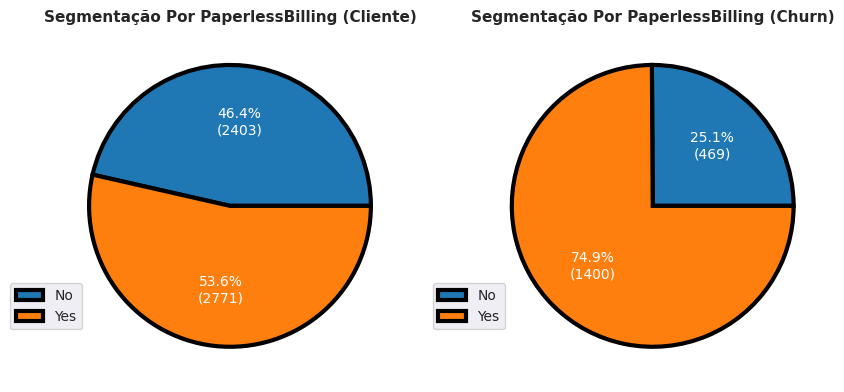

In [34]:
dfChurn = dfDados[(dfDados['Churn'] == 1) ]
dfCliente = dfDados[(dfDados['Churn'] == 0)  ]

DesenhaPizza  (
              dfChurn,
              dfCliente,
              "PaperlessBilling",
              "Segmentação Por PaperlessBilling (Cliente)",
              "Segmentação Por PaperlessBilling (Churn)",
              ['No', 'Yes'	]
              )


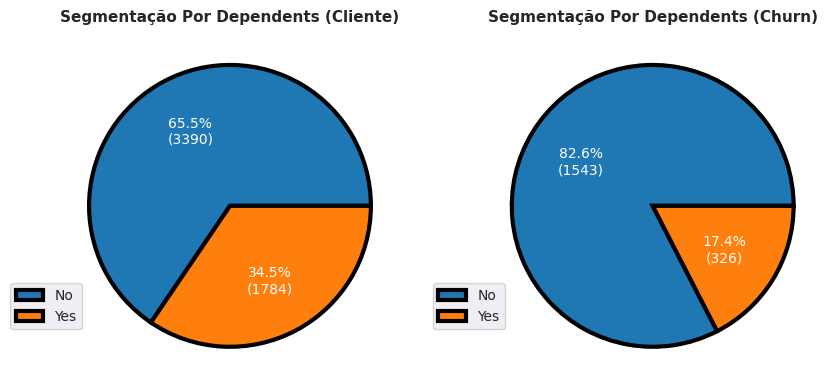

In [35]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "Dependents",
              "Segmentação Por Dependents (Cliente)",
              "Segmentação Por Dependents (Churn)",
              ['No', 'Yes'	]
              )


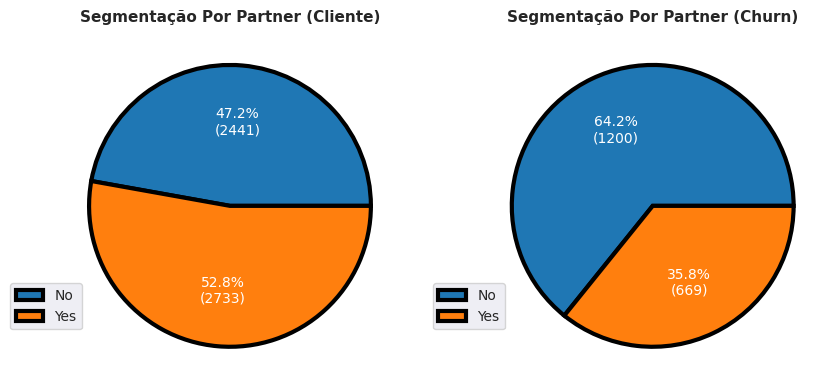

In [36]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "Partner",
              "Segmentação Por Partner (Cliente)",
              "Segmentação Por Partner (Churn)",
              ['No', 'Yes'	]
              )


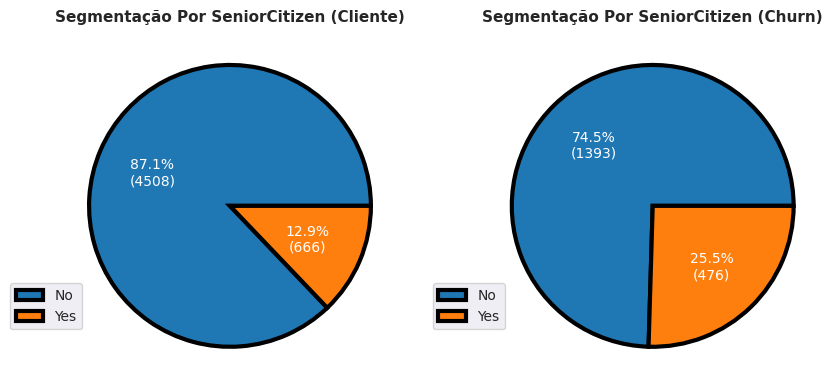

In [37]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "SeniorCitizen",
              "Segmentação Por SeniorCitizen (Cliente)",
              "Segmentação Por SeniorCitizen (Churn)",
              ['No', 'Yes'	]
              )


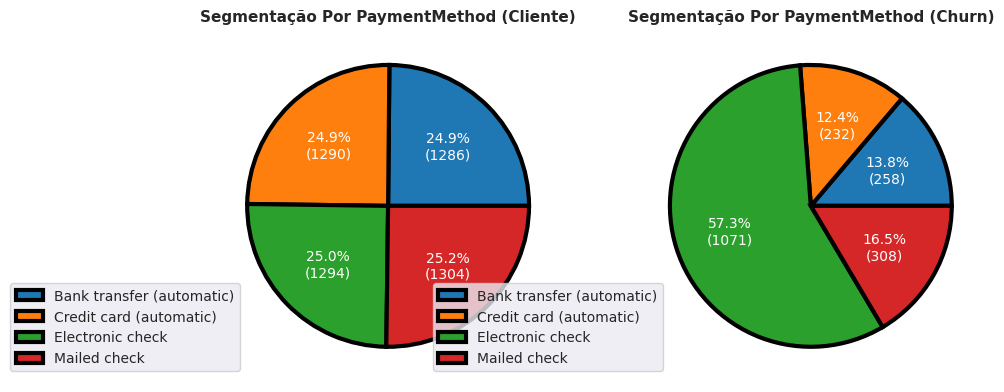

In [38]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "PaymentMethod",
              "Segmentação Por PaymentMethod (Cliente)",
              "Segmentação Por PaymentMethod (Churn)",
              ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check'	]
              )


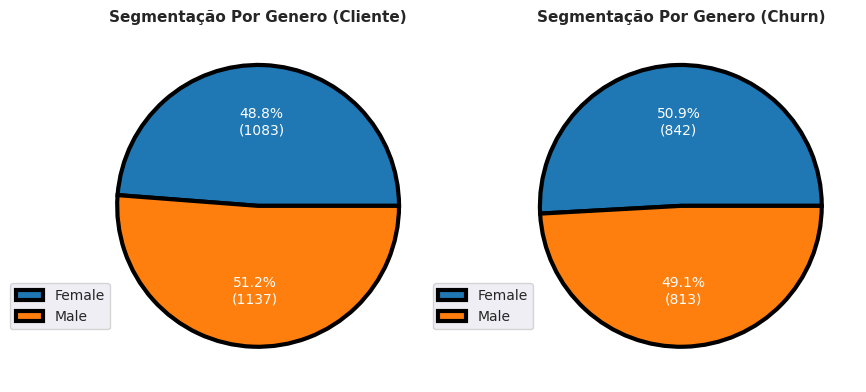

In [39]:
dfChurn = dfDados[(dfDados['Churn'] == 1) & (dfDados['Contract']==0)]
dfCliente = dfDados[(dfDados['Churn'] == 0) & (dfDados['Contract']==0)]

DesenhaPizza  (
              dfChurn,
              dfCliente,
              "gender",
              "Segmentação Por Genero (Cliente)",
              "Segmentação Por Genero (Churn)",
              ['Female', 'Male'	]
              )


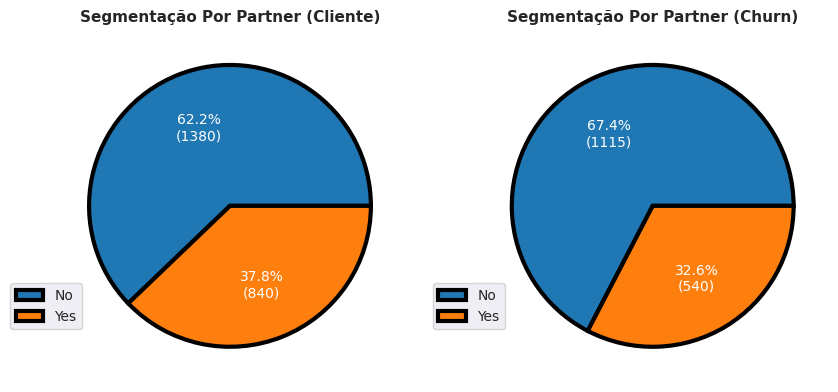

In [40]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "Partner",
              "Segmentação Por Partner (Cliente)",
              "Segmentação Por Partner (Churn)",
              ["No", "Yes"]
              )


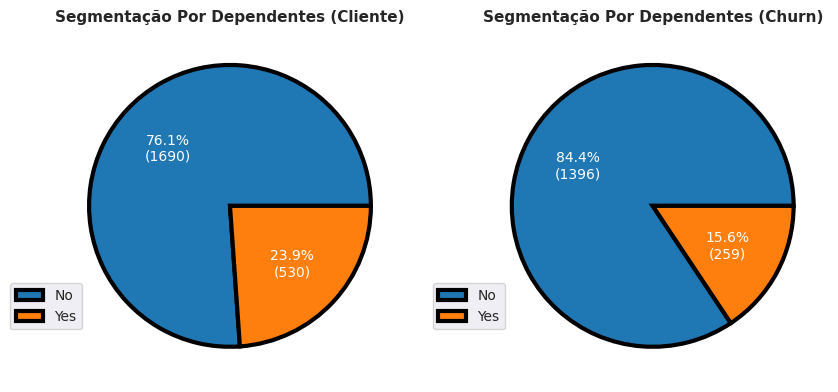

In [41]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "Dependents",
              "Segmentação Por Dependentes (Cliente)",
              "Segmentação Por Dependentes (Churn)",
              ["No", "Yes"]
              )


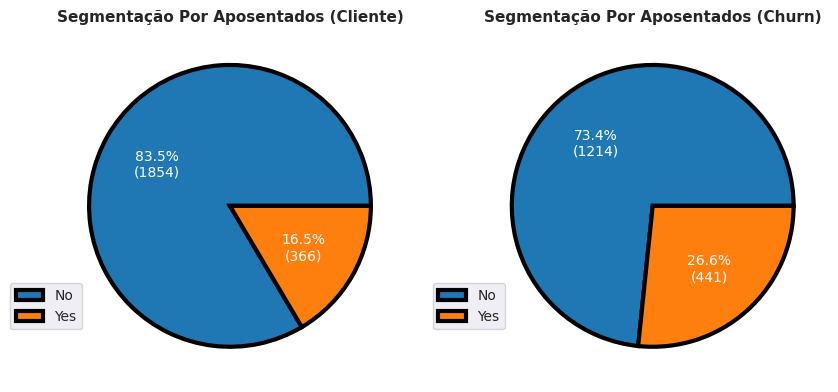

In [42]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "SeniorCitizen",
              "Segmentação Por Aposentados (Cliente)",
              "Segmentação Por Aposentados (Churn)",
              [ "No", "Yes"]
              )

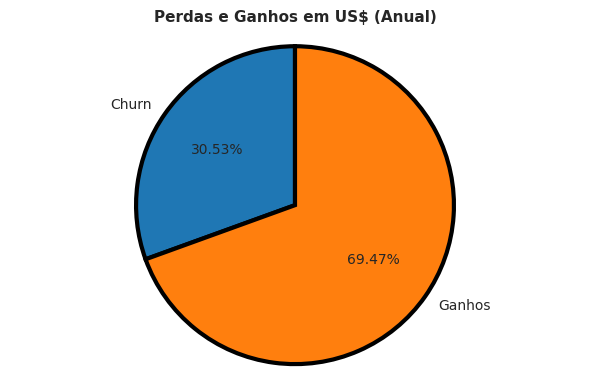

In [43]:
MontaPizza  (
            ["Churn", "Ganhos"],
            CalculaPerdas ( dfDados ),
            "Perdas e Ganhos em US$ (Anual)"
            )


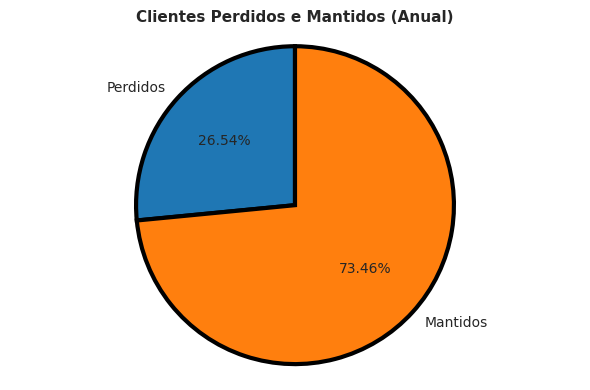

In [44]:
MontaPizza  (
            ["Perdidos", "Mantidos"],
            ContaClientes ( dfDados ),
            "Clientes Perdidos e Mantidos (Anual)"
            )


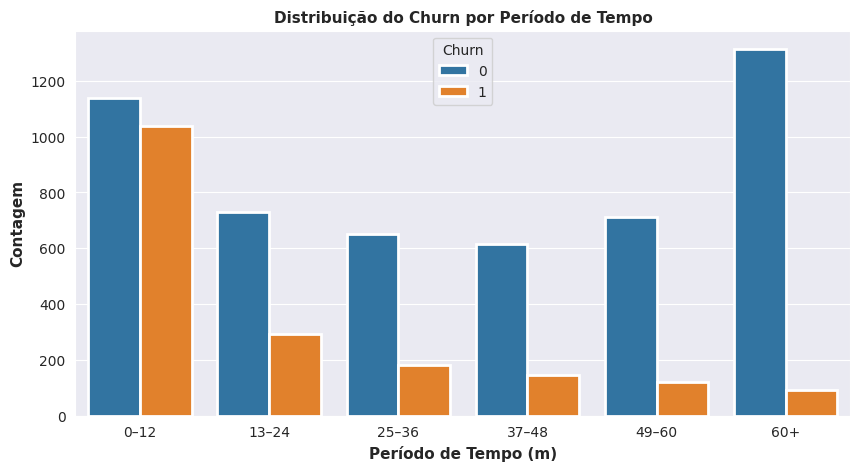

In [45]:
dfDadosAux = dfDados.copy()
dfDadosAux["TenureGrp"] = pd.cut(dfDados["tenure"], bins=[0,12,24,36,48,60,np.inf], labels=["0–12", "13–24", "25–36", "37–48", "49–60", "60+"])
Grafico = plt.figure( figsize=(10, 5))
sns.set_style("darkgrid")

sns.countplot ( data=dfDadosAux, x = dfDadosAux["TenureGrp"], lw=2, hue = "Churn" )
plt.title("Distribuição do Churn por Período de Tempo", fontsize=11, fontweight="bold")
plt.ylabel("Contagem", fontsize=11, fontweight="bold")
plt.xlabel("Período de Tempo (m)", fontsize=11, fontweight="bold" )
plt.show()

del (dfDadosAux, Grafico)

# **Estudo das Densidades**

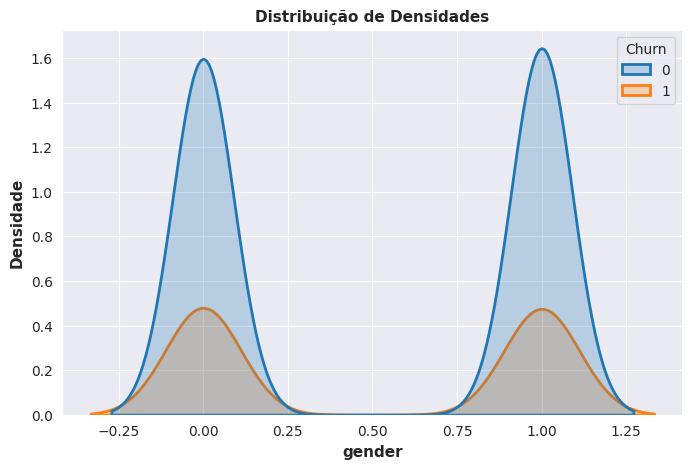

In [46]:
DesenhaDensidades (dfDados, "gender")


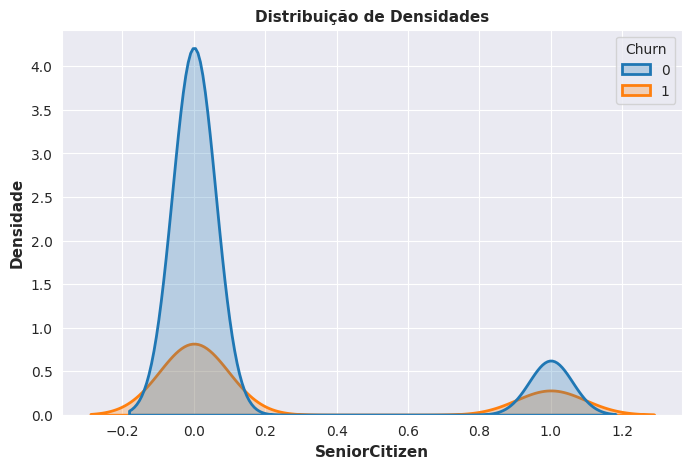

In [47]:
DesenhaDensidades (dfDados, "SeniorCitizen")


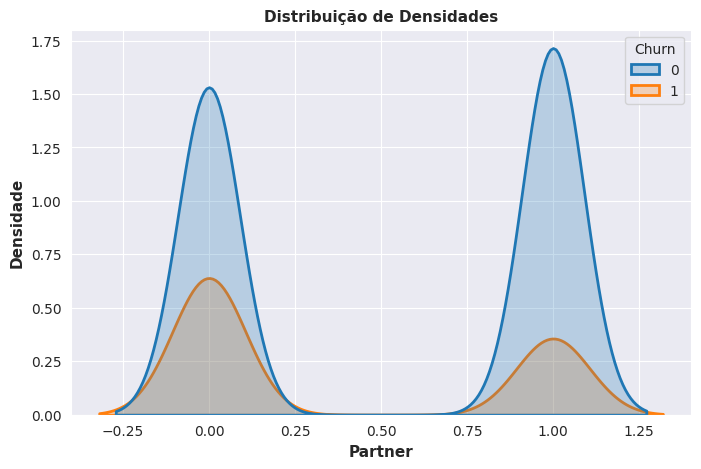

In [48]:
DesenhaDensidades (dfDados, "Partner"  )


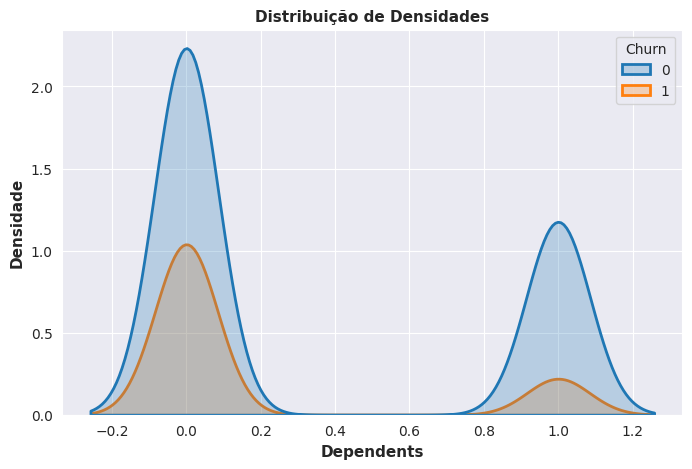

In [49]:
DesenhaDensidades (dfDados, "Dependents")


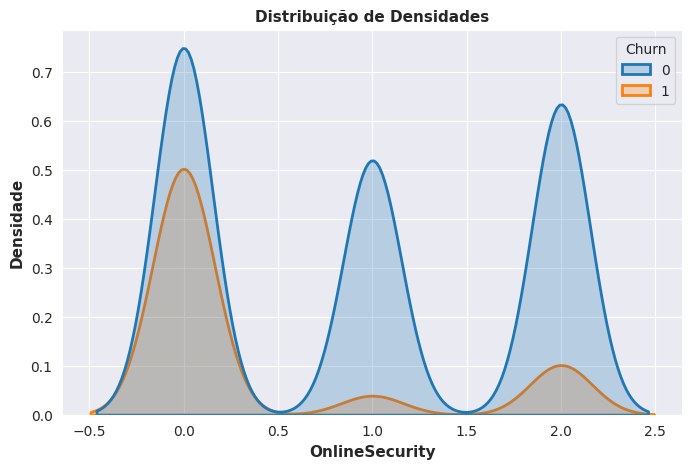

In [50]:
DesenhaDensidades (dfDados,  "OnlineSecurity" )


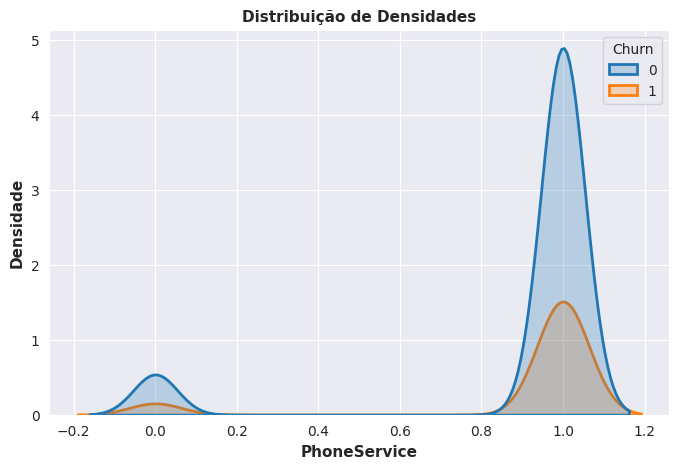

In [51]:
DesenhaDensidades (dfDados, "PhoneService")


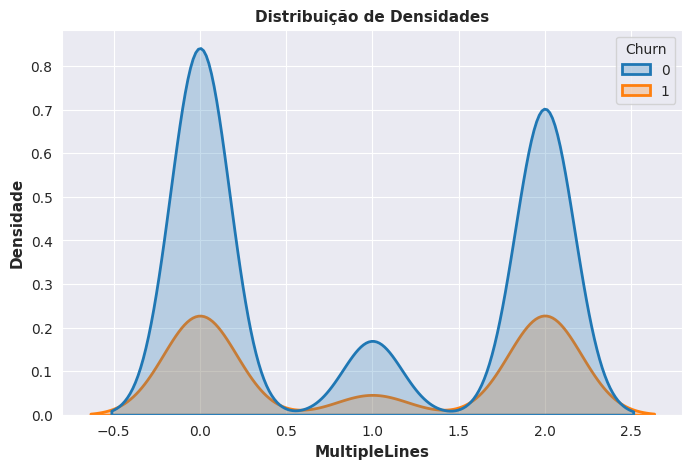

In [52]:
DesenhaDensidades (dfDados, "MultipleLines" )


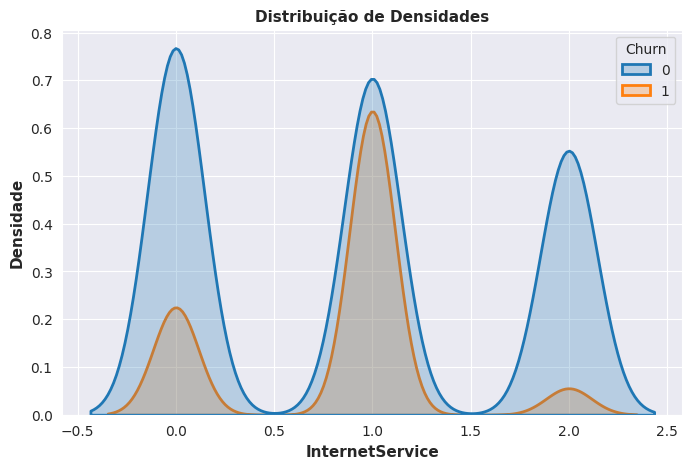

In [53]:
DesenhaDensidades (dfDados, "InternetService")


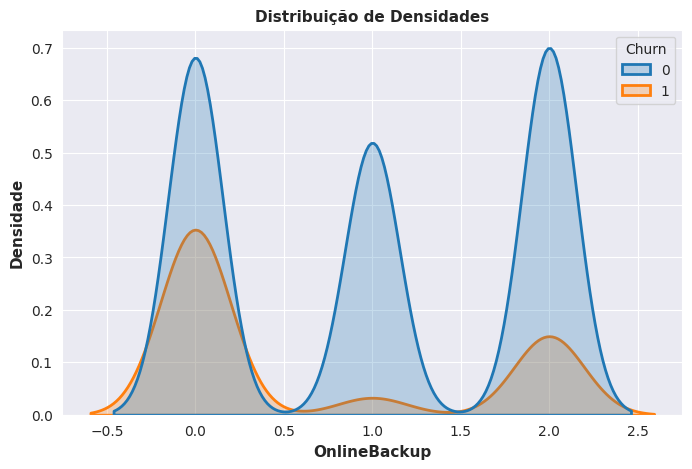

In [54]:
DesenhaDensidades (dfDados, "OnlineBackup" )


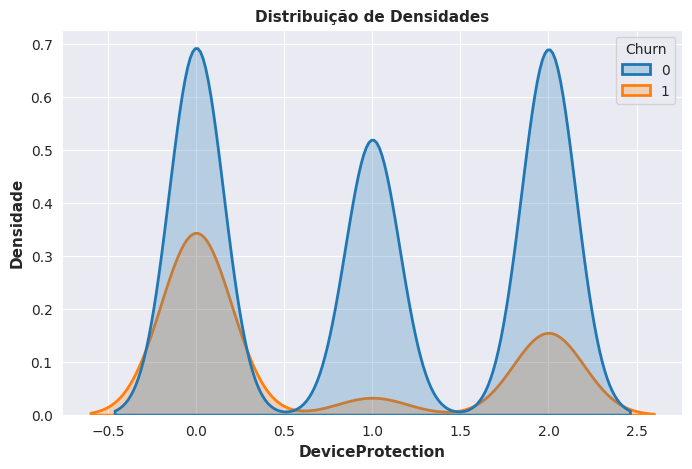

In [55]:
DesenhaDensidades (dfDados,  "DeviceProtection" )


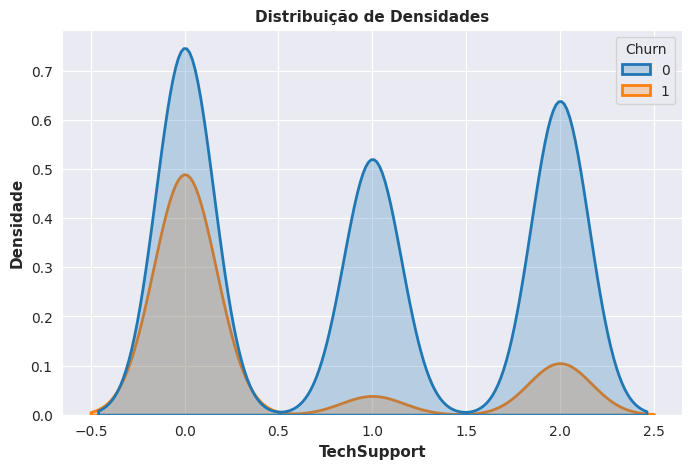

In [56]:
DesenhaDensidades (dfDados,  "TechSupport" )


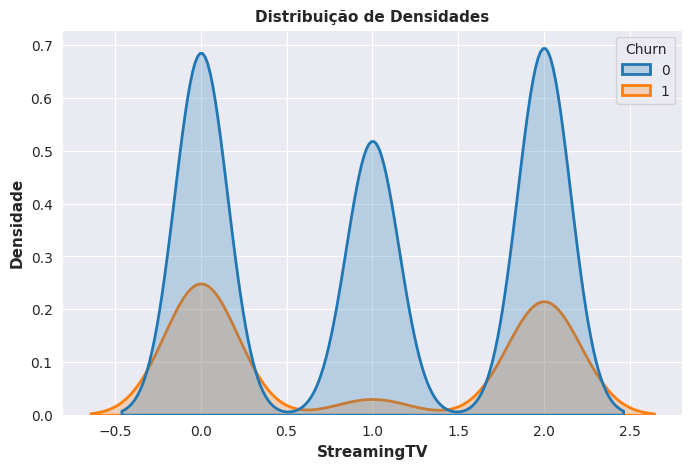

In [57]:
DesenhaDensidades (dfDados, "StreamingTV")


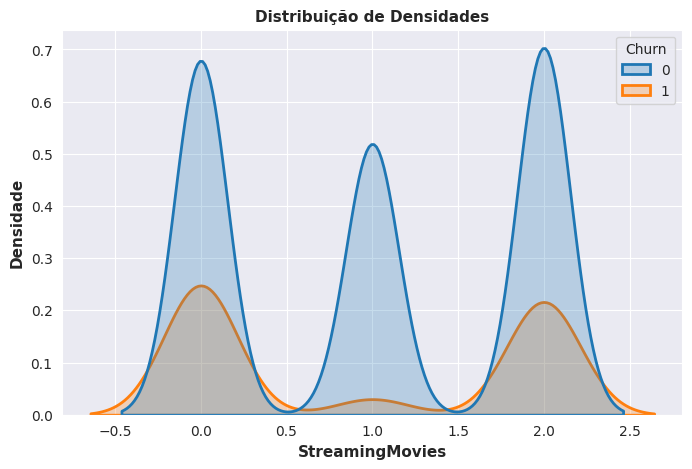

In [58]:
DesenhaDensidades (dfDados, "StreamingMovies")


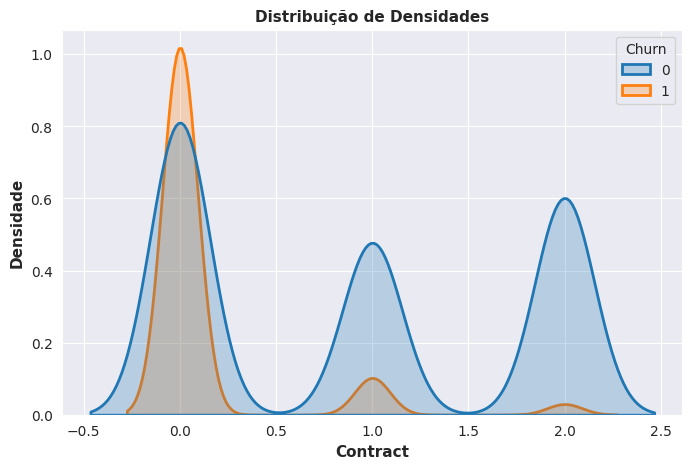

In [59]:
DesenhaDensidades (dfDados, "Contract")


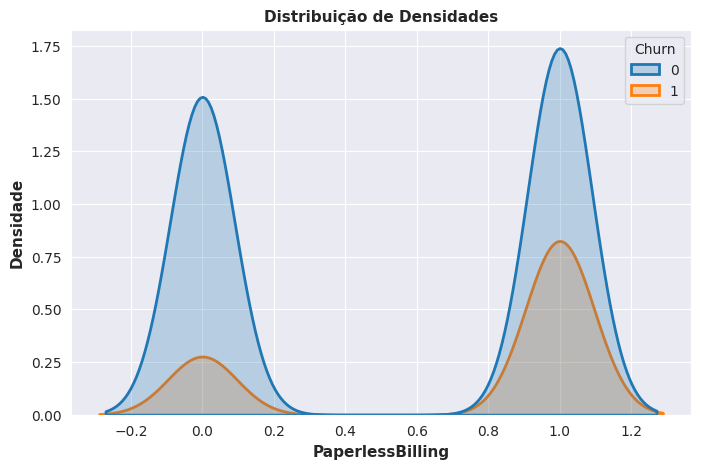

In [60]:
DesenhaDensidades (dfDados, "PaperlessBilling")


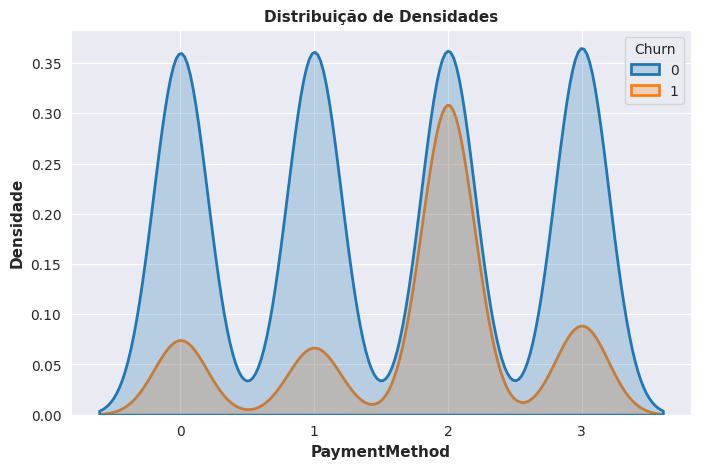

In [61]:
DesenhaDensidades (dfDados,  "PaymentMethod" )


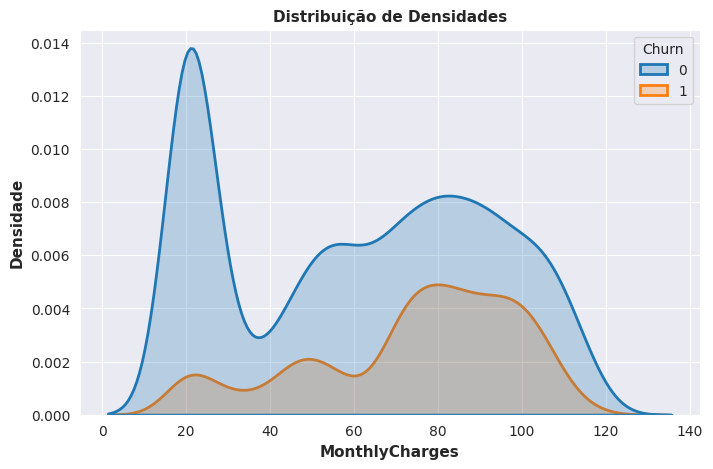

In [62]:
DesenhaDensidades (dfDados, "MonthlyCharges" )


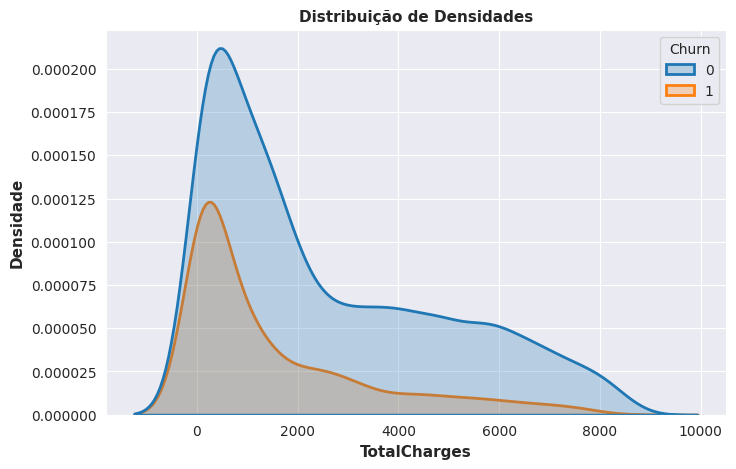

In [63]:
DesenhaDensidades (dfDados, "TotalCharges" )


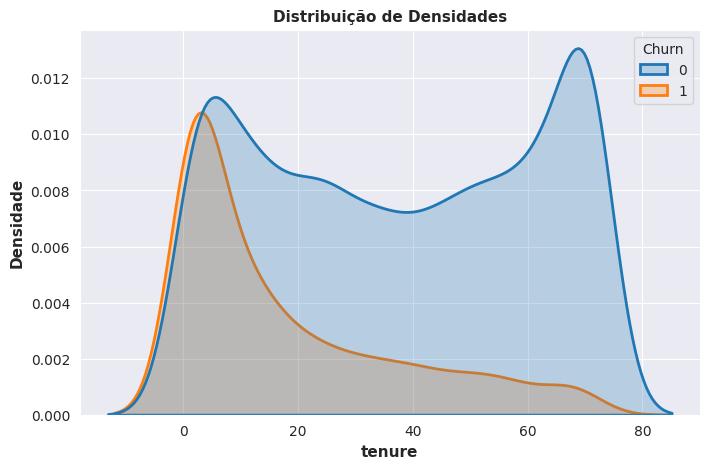

In [64]:
DesenhaDensidades (dfDados, "tenure" )


# **Entendendo as Condições de Oportunidades em 12 Meses**

In [65]:
dfChurn = dfDados[(dfDados['Churn'] == 1) & (dfDados["tenure"] <= 12)]
dfCliente = dfDados[(dfDados['Churn'] == 0) & (dfDados["tenure"] <= 12)]


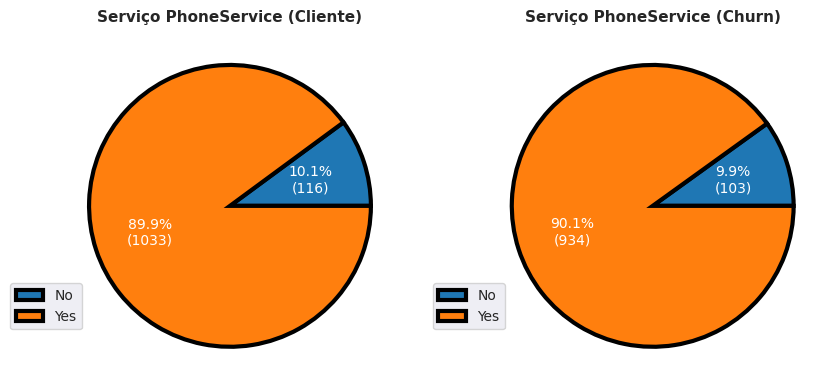

In [66]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "PhoneService",
              "Serviço PhoneService (Cliente)",
              "Serviço PhoneService (Churn)",
              ['No', 'Yes' ]
              )


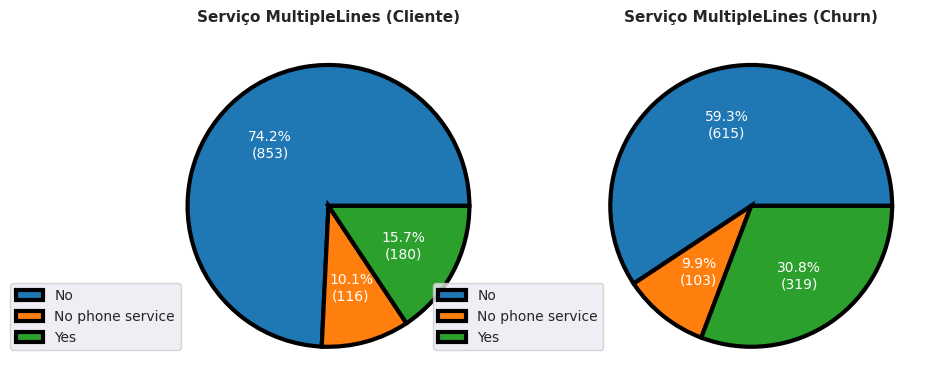

In [67]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "MultipleLines",
              "Serviço MultipleLines (Cliente)",
              "Serviço MultipleLines (Churn)",
              ['No', 'No phone service', 'Yes' ]
              )


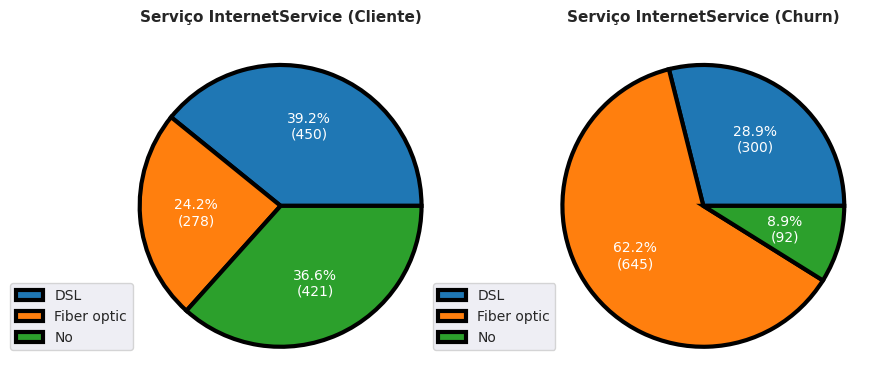

In [68]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "InternetService",
              "Serviço InternetService (Cliente)",
              "Serviço InternetService (Churn)",
              ['DSL', 'Fiber optic', 'No' ]
              )



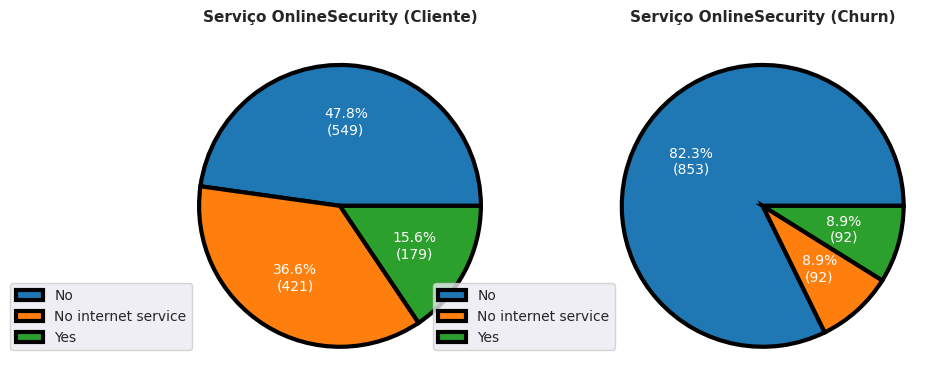

In [69]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "OnlineSecurity",
              "Serviço OnlineSecurity (Cliente)",
              "Serviço OnlineSecurity (Churn)",
              ['No', 'No internet service', 'Yes' ]
              )


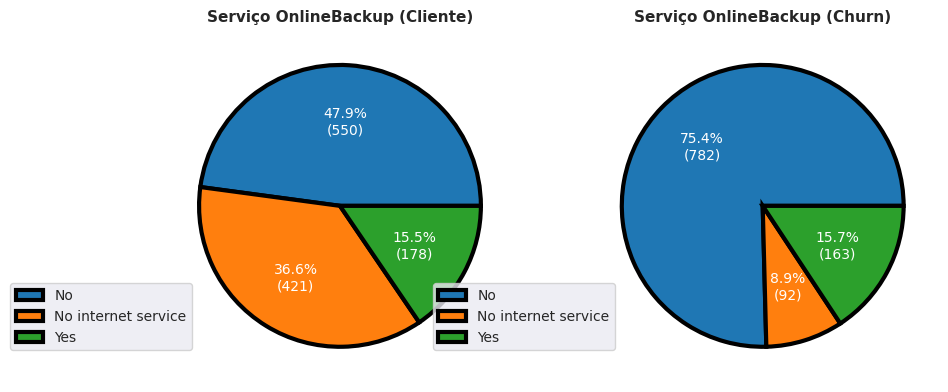

In [70]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "OnlineBackup",
              "Serviço OnlineBackup (Cliente)",
              "Serviço OnlineBackup (Churn)",
              ['No', 'No internet service', 'Yes' ]
              )


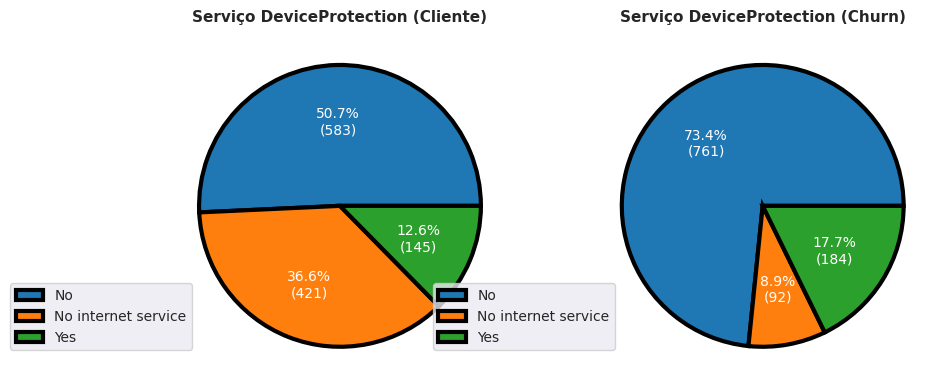

In [71]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "DeviceProtection",
              "Serviço DeviceProtection (Cliente)",
              "Serviço DeviceProtection (Churn)",
              ['No', 'No internet service', 'Yes' ]
              )


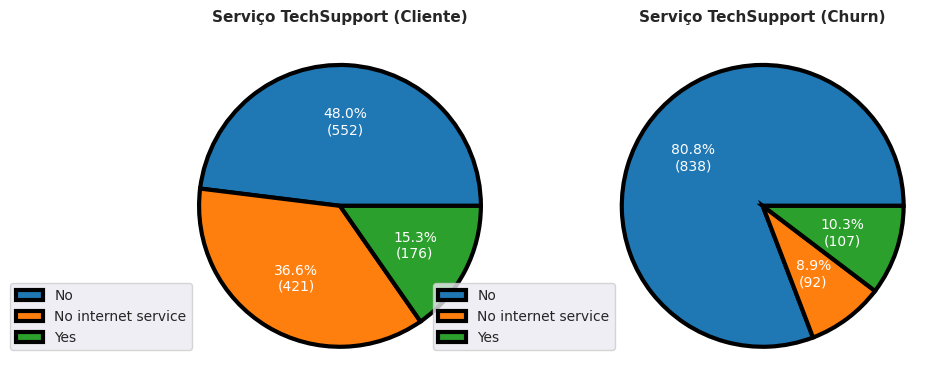

In [72]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "TechSupport",
              "Serviço TechSupport (Cliente)",
              "Serviço TechSupport (Churn)",
              ['No', 'No internet service', 'Yes' ]
              )


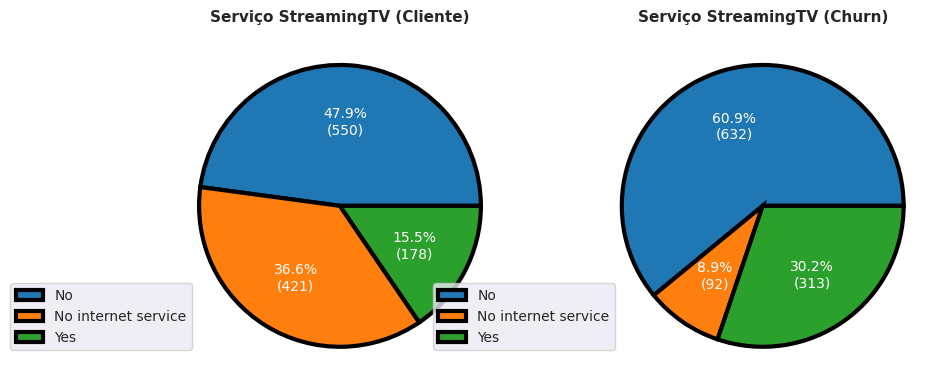

In [73]:
DesenhaPizza  (
              dfChurn,
              dfCliente,
              "StreamingTV",
              "Serviço StreamingTV (Cliente)",
              "Serviço StreamingTV (Churn)",
              ['No', 'No internet service', 'Yes' ]
              )


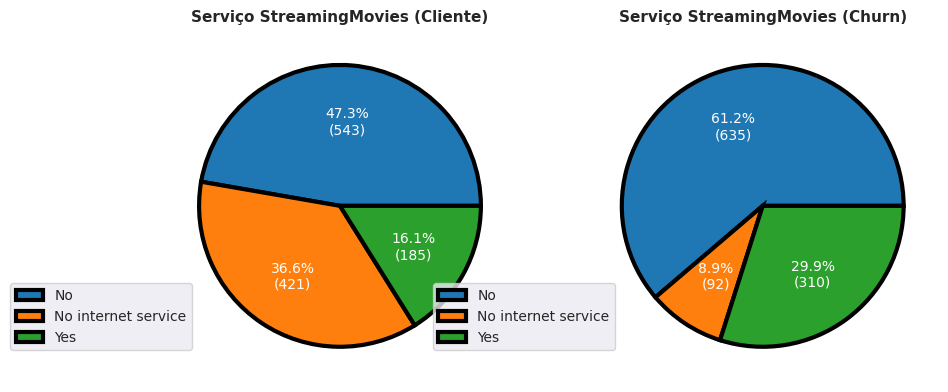

In [74]:
DesenhaPizza (
              dfChurn,
              dfCliente,
              "StreamingMovies",
              "Serviço StreamingMovies (Cliente)",
              "Serviço StreamingMovies (Churn)",
              ['No', 'No internet service', 'Yes' ]
              )


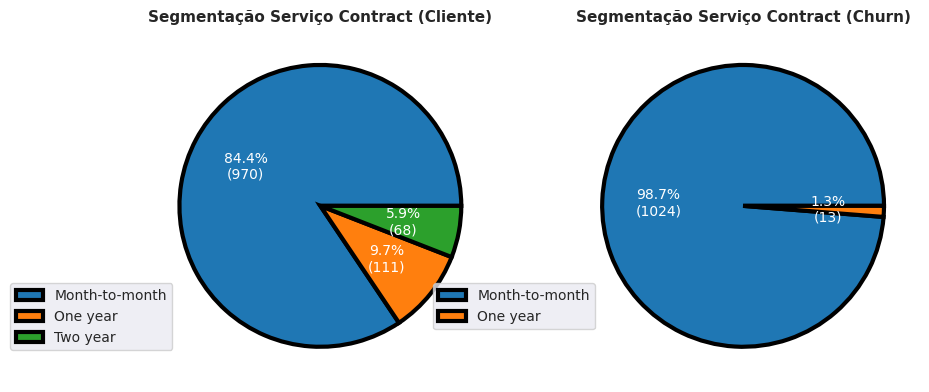

In [75]:
DesenhaPizza (
              dfChurn,
              dfCliente,
              "Contract",
              "Segmentação Serviço Contract (Cliente)",
              "Segmentação Serviço Contract (Churn)",
              ['Month-to-month', 'One year', 'Two year'	]
              )


# **Componentes Candidatas a Exclusão**

## **Score da Informação Mútua**

In [76]:
Componentes = [ "gender", "Partner", "Dependents", "PhoneService",
                "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
                "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
                "Contract", "PaperlessBilling", "PaymentMethod", "Churn",
                'tenure']

SIMTelco = dfDados[Componentes].drop(columns=["Churn"]).apply(lambda x:mutual_info_score(x,dfDados["Churn"])).sort_values(ascending=False)
dfTelco = pd.DataFrame({ "Componente":SIMTelco.index, "Coeficiente":SIMTelco.values})

[]

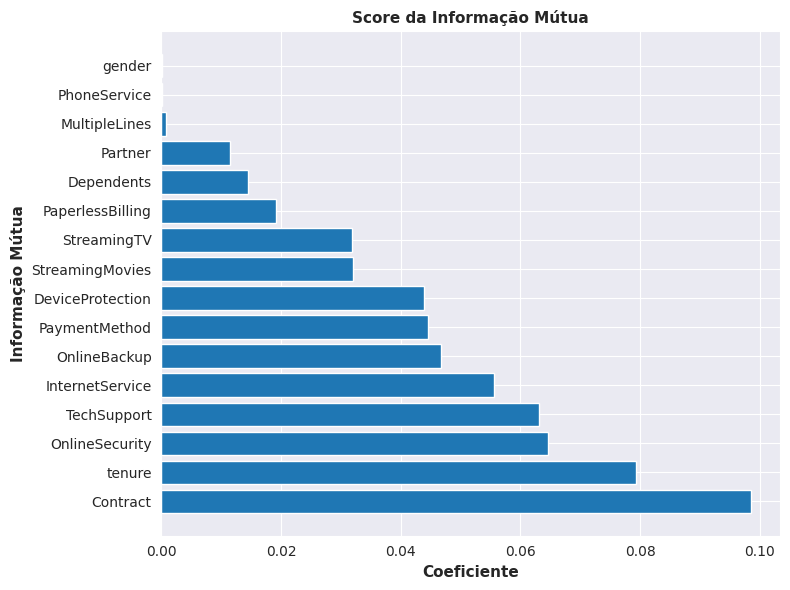

In [77]:
Grafico = plt.figure( figsize=(8, 6))
sns.set_style("darkgrid")

plt.barh ( dfTelco["Componente"], dfTelco["Coeficiente"] )
plt.title("Score da Informação Mútua", fontsize=11, fontweight="bold")
plt.ylabel("Informação Mútua", fontsize=11, fontweight="bold")
plt.xlabel("Coeficiente", fontsize=11, fontweight="bold")
plt.tight_layout()
plt.plot ()


## **Eliminando Componentes Pouco Relevantes**

In [78]:
dfDados = dfDados.drop(["gender", "PhoneService"], axis=1)


## **Padronização da Escala**

In [79]:
PadraoEscala = StandardScaler()
DadosEscalados = PadraoEscala.fit_transform(dfDados[["MonthlyCharges"]])
dfDados["MonthlyCharges"] = DadosEscalados

DadosEscalados = PadraoEscala.fit_transform(dfDados[["TotalCharges"]])
dfDados["TotalCharges"] = DadosEscalados


# **Criação e Ajustes das Bases de Dados**

## **Criação das Classes**

In [80]:
XOriginal = dfDados.copy (deep=True)
XOriginal = XOriginal.drop(["Churn"], axis=1)
XOriginal = XOriginal.drop(["customerID"], axis=1)
yOriginal = dfDados["Churn"]


## **Criação dos Grupos de Treino e Teste**

In [81]:
XTreino, XTeste, \
yTreino, yTeste = train_test_split  (
                                    XOriginal,
                                    yOriginal,
                                    random_state = SEMENTE,
                                    test_size = 0.30,
                                    shuffle = True
                                    )


## **Balanceando os Dados**

In [82]:
Balanco = SMOTE ()
bXtreino, byTreino = Balanco.fit_resample (XTreino, yTreino)


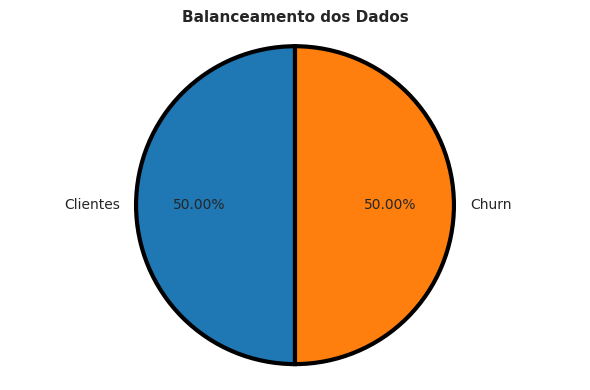

In [83]:
Labels = "Clientes", "Churn"
Quantidade = [len(bXtreino), len(byTreino) ]

Grafico = plt.figure( figsize=(6, 4))
sns.set_style("darkgrid")

plt.title("Balanceamento dos Dados", fontsize=11, fontweight="bold")
plt.pie (
        Quantidade,
        labels = Labels,
        autopct = "%1.2f%%",
        wedgeprops = {
                        "linewidth" : 3,
                        "edgecolor" : "black"
                     },
        startangle=90
        )

plt.axis("equal")
plt.tight_layout()
plt.show()


# **Criação do Modelo do Classificador**

In [84]:
Modelo = AdaBoostClassifier()
HiperParametros = dict()
HiperParametros['n_estimators'] = [1, 5, 10, 50, 100, 150]
HiperParametros['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
HiperParametros['algorithm'] = ['SAMME', 'SAMME.R']

Folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEMENTE)
GridSearch = GridSearchCV(estimator=Modelo, param_grid=HiperParametros, n_jobs=-1, cv=Folds, scoring='f1')

GridResultado = GridSearch.fit(XTreino, yTreino)
print("Melhor Escolha: %f Usando %s" % (GridResultado.best_score_, GridResultado.best_params_))


Melhor Escolha: 0.591198 Usando {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 150}


In [85]:
Modelo = AdaBoostClassifier(n_estimators = 150, learning_rate = 1.0, algorithm="SAMME")
yPredito = Modelo.fit(bXtreino, byTreino)

yPreditoProba = Modelo.predict_proba(XTeste)
yPredito = Modelo.predict(XTeste)

print ( "########################################################################" )
print ( "# Relatório da Classificação" )
print ( "########################################################################" )
print(classification_report (
                                yTeste,
                                yPredito,
                                target_names=["Cliente", "Churn"],
                                digits=2
                            ))

########################################################################
# Relatório da Classificação
########################################################################
              precision    recall  f1-score   support

     Cliente       0.87      0.80      0.83      1536
       Churn       0.56      0.69      0.62       577

    accuracy                           0.77      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.77      0.77      2113



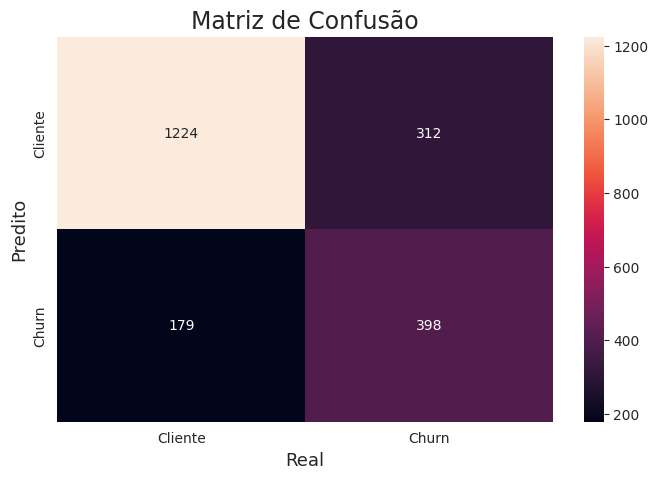

In [86]:
Grafico = plt.figure( figsize=(8, 5))
sns.set_style("darkgrid")

cm = confusion_matrix(yTeste, yPredito)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Cliente','Churn'],
            yticklabels=['Cliente','Churn'])

plt.ylabel('Predito',fontsize=13)
plt.xlabel('Real',fontsize=13)
plt.title('Matriz de Confusão',fontsize=17)
plt.show()

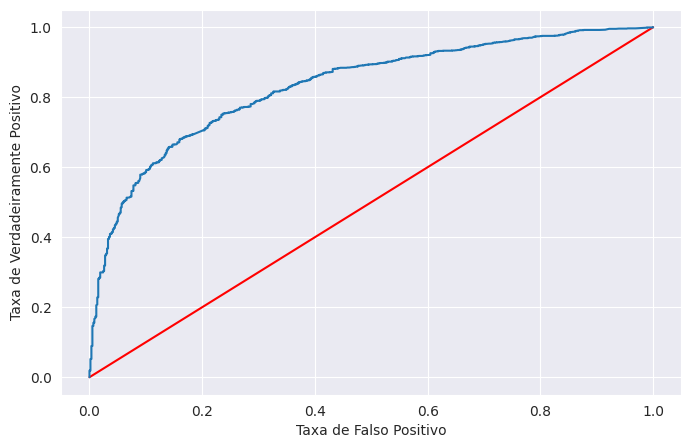

AUC: 0.831438881065858


In [87]:
Grafico = plt.figure( figsize=(8, 5))
sns.set_style("darkgrid")

y_true = yTeste
y_probas = yPreditoProba[:, 0]
fpr, tpr, thresholds = roc_curve(y_true, (y_probas), pos_label=0)

plt.plot([0,1], [0,1],color="red" )
plt.plot(fpr,tpr)
plt.ylabel('Taxa de Verdadeiramente Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

auc = np.trapz(tpr,fpr)
print('AUC:', auc)
plt.show ()


# **Avaliação de Insights Oriundas do Modelo**

## **Efeito Global das Componentes**

PermutationExplainer explainer: 2114it [16:35,  2.11it/s]


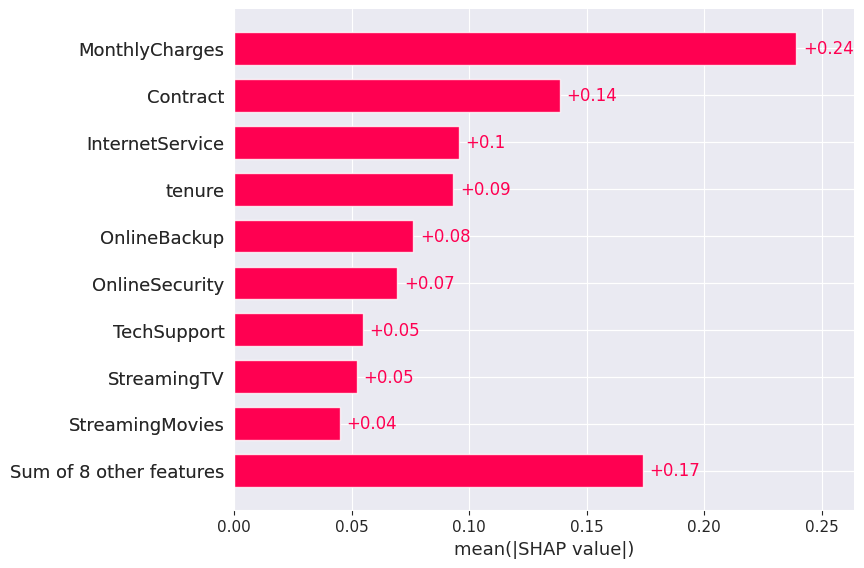

In [88]:
explainer = shap.Explainer(Modelo.predict, bXtreino)
shap_values = explainer(XTeste)
shap.plots.bar(shap_values)

## **Comportamento das Componentes no Modelo**

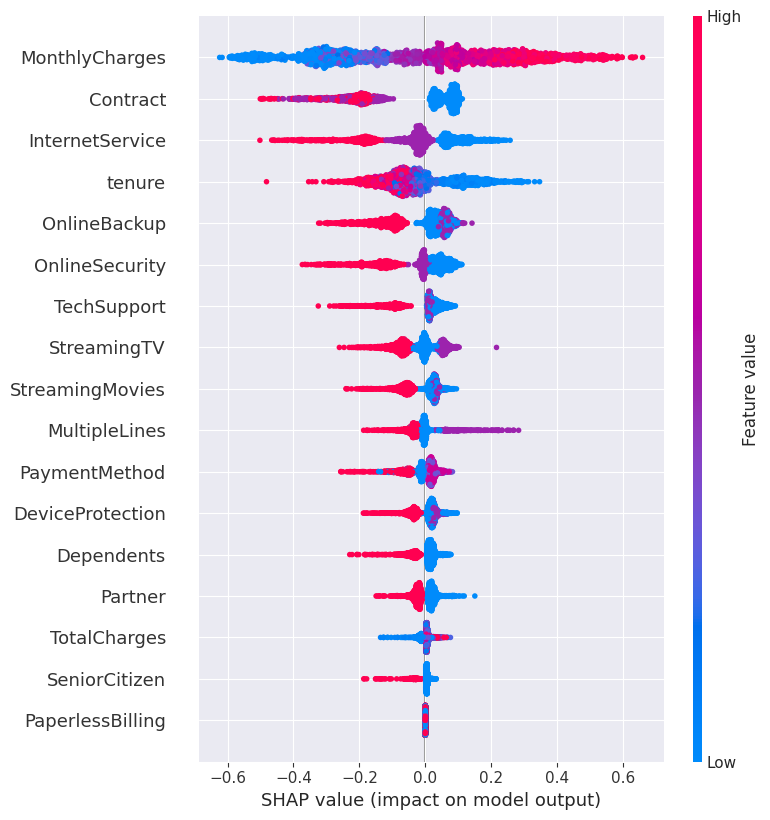

In [89]:
shap.summary_plot(shap_values)